In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
data = pd.read_csv('三并柜数据.csv', index_col=0)
data['Time'] = pd.to_datetime(data['Time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516463 entries, 0 to 516462
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Time    516463 non-null  datetime64[ns]
 1   CN      516463 non-null  float64       
 2   SD      516463 non-null  float64       
 3   FH      516463 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 19.7 MB


In [21]:
data_FH = data.drop(['CN','SD'],axis=1)
data_FH.set_index('Time', inplace=True)
data_FH

,FH
Time,
2023-05-21 00:00:00,403.2
2023-05-21 00:00:15,400.6
2023-05-21 00:00:30,384.3
2023-05-21 00:00:45,385.3
2023-05-21 00:01:00,394.3
...,...
2023-08-18 23:58:45,585.1
2023-08-18 23:59:00,588.4
2023-08-18 23:59:15,578.6


In [22]:
# df是时间补全的数据
time_index = pd.date_range(start=data.iloc[0,0],end=data.iloc[-1,0], freq='15S')
df = pd.DataFrame(index = time_index,columns=['FH'])
df['FH'] = data_FH['FH']
df

,FH
2023-05-21 00:00:00,403.2
2023-05-21 00:00:15,400.6
2023-05-21 00:00:30,384.3
2023-05-21 00:00:45,385.3
2023-05-21 00:01:00,394.3
...,...
2023-08-18 23:58:45,585.1
2023-08-18 23:59:00,588.4
2023-08-18 23:59:15,578.6
2023-08-18 23:59:30,603.4


In [23]:
df.isna().sum()

FH    2944
dtype: int64

In [24]:
# 记录原始数据和填充后的数据的索引
original_index = set(data_FH.index)
new_index = set(df.index)

# 找出没有被填充的原始数据索引
missing_indices = original_index - new_index
# 从原始数据中提取缺失的行
missing_rows = data_FH.loc[data_FH.index.isin(missing_indices)]
missing_rows

,FH
Time,
2023-05-21 04:06:02,402.7
2023-05-21 04:41:03,361.6
2023-05-21 04:42:32,369.7
2023-05-21 04:47:18,354.0
2023-05-21 04:49:01,360.2
...,...
2023-08-18 21:47:03,329.1
2023-08-18 21:51:46,526.7
2023-08-18 22:38:16,594.2


In [25]:
from datetime import timedelta
for i in range(missing_rows.shape[0]):
    seconds  = missing_rows.index[i].second
    nearest_15_1 = int(seconds / 15) * 15
    nearest_15_2 = int(seconds / 15) * 15 + 15
    # 计算秒数的调整量
    delta_seconds_1 = nearest_15_1 - seconds
    delta_seconds_2 = nearest_15_2 - seconds
    # 创建时间戳的调整时间
    adjusted_ts_1 = missing_rows.index[i] + timedelta(seconds=delta_seconds_1)
    adjusted_ts_2 = missing_rows.index[i] + timedelta(seconds=delta_seconds_2)
    if pd.isna(df.loc[adjusted_ts_1,'FH']):
        df.loc[adjusted_ts_1,'FH'] = missing_rows.iloc[i,0]
    elif pd.isna(df.loc[adjusted_ts_2,'FH']):
        df.loc[adjusted_ts_2,'FH'] = missing_rows.iloc[i,0]
df.isna().sum()

FH    1937
dtype: int64

In [26]:
df[df.isna().any(axis=1)].index

DatetimeIndex(['2023-06-09 14:52:00', '2023-06-09 14:52:15',
               '2023-06-09 14:52:30', '2023-06-13 11:30:30',
               '2023-06-13 11:30:45', '2023-06-13 11:31:00',
               '2023-06-14 13:28:30', '2023-06-14 13:28:45',
               '2023-06-14 13:29:00', '2023-06-14 18:41:30',
               ...
               '2023-07-13 07:01:15', '2023-07-13 07:01:30',
               '2023-07-13 07:02:00', '2023-07-16 10:22:30',
               '2023-07-16 10:22:45', '2023-07-16 22:49:30',
               '2023-07-16 22:49:45', '2023-07-16 22:50:00',
               '2023-07-17 11:33:00', '2023-07-17 11:33:15'],
              dtype='datetime64[ns]', length=1937, freq=None)

In [27]:
from scipy.interpolate import UnivariateSpline
# 线性插值
df_linear_interpolated = df.interpolate(method='linear')

# 样条插值（使用 UnivariateSpline）
# 需要将时间戳转换为数值形式
df_spline_interpolated = df.copy()
df_spline_interpolated['FH'] = df_spline_interpolated['FH'].interpolate(method='linear')  # 先线性插值填充缺失值

# 使用 UnivariateSpline 进行周期性插值
x = np.arange(len(df_spline_interpolated))
y = df_spline_interpolated['FH'].values
spline = UnivariateSpline(x, y, s=0, k=3)  # k=3 为三次样条插值
df_spline_interpolated['FH'] = spline(x)

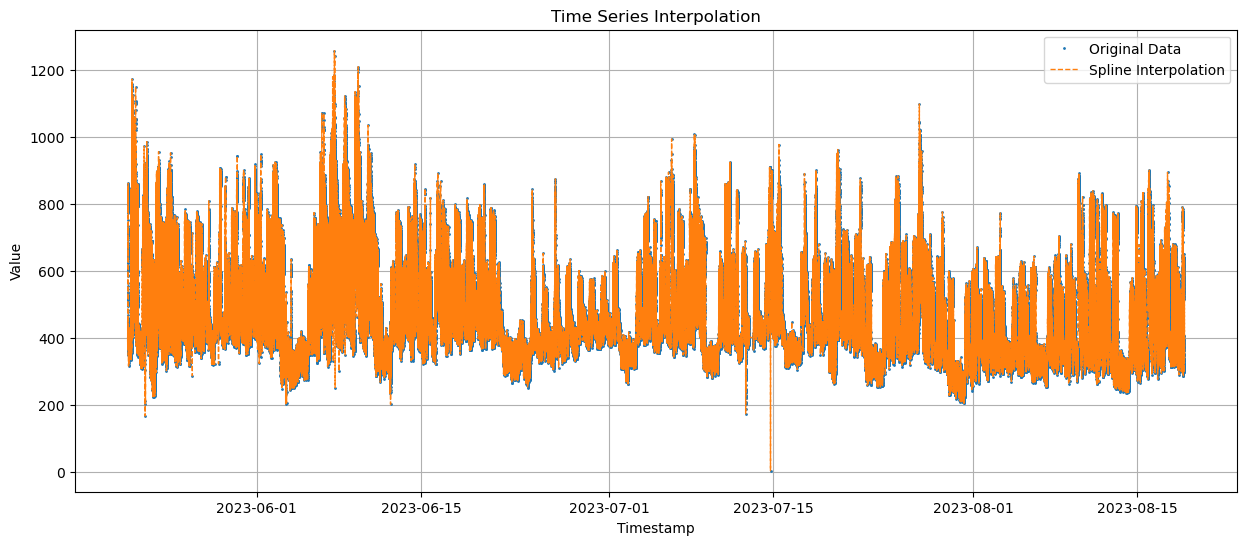

In [30]:
# 可视化
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['FH'], 'o', label='Original Data',markersize=1)
#plt.plot(df_linear_interpolated.index, df_linear_interpolated['FH'], '-', label='Linear Interpolation',linewidth=1)
plt.plot(df_spline_interpolated.index, df_spline_interpolated['FH'], '--', label='Spline Interpolation',linewidth=1)
plt.legend()
plt.title('Time Series Interpolation')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.grid(True)
#plt.savefig('线性插值和周期样条插值补全2024-2-4以前的少量数据.png',dpi=500)
plt.show()

In [31]:
df['FH'] = df_spline_interpolated['FH']
df.isna().sum()
# 查看nan值的行数可以发现只剩下2024-02-03到2024-02-20的数据还未补全

FH    0
dtype: int64

In [32]:
df.to_csv('三并柜补全数据.csv')

In [13]:
df1 = df.loc[df.index < '2024-02-04']
df1

,FH
2023-11-03 00:00:00,73.8
2023-11-03 00:00:15,73.2
2023-11-03 00:00:30,74.1
2023-11-03 00:00:45,75.5
2023-11-03 00:01:00,75.5
...,...
2024-02-03 23:58:45,20.1
2024-02-03 23:59:00,20.4
2024-02-03 23:59:15,20.7
2024-02-03 23:59:30,20.7


# SARIMA

C:\Users\25492\AppData\Local\Temp\ipykernel_14152\3929901552.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pacf.show()
C:\Users\25492\AppData\Local\Temp\ipykernel_14152\3929901552.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  acf.show()


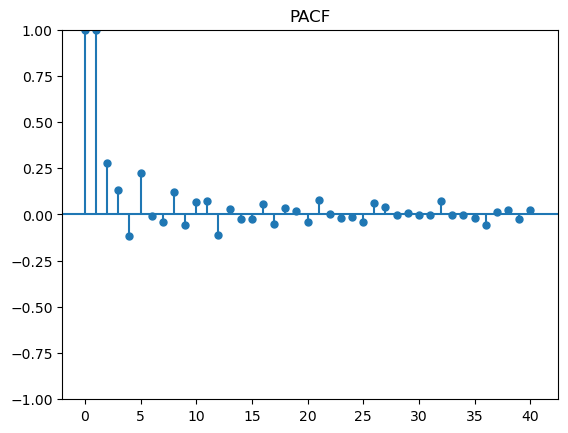

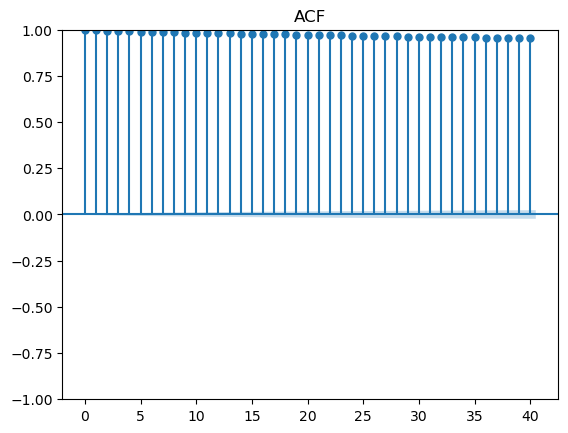

In [14]:
"""ACF,PACF图"""
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(df1, lags=40)
plt.title('PACF')
pacf.show()
acf = plot_acf(df1, lags=40)
plt.title('ACF')
acf.show()

In [33]:
# 一阶差分
diff1 = df1.diff(1)
# 24步差分
diff_seasonal = diff1.diff(60)  # 非平稳序列经过d阶常差分和D阶季节差分变为平稳时间序列
# 十二步季节差分平稳性检验结果
diff_seasonal

2023-11-03 00:00:00             NaN
2023-11-03 00:00:15             NaN
2023-11-03 00:00:30             NaN
2023-11-03 00:00:45             NaN
2023-11-03 00:01:00             NaN
                           ...     
2024-02-02 23:59:00   -1.110223e-16
2024-02-02 23:59:15    3.330669e-16
2024-02-02 23:59:30    0.000000e+00
2024-02-02 23:59:45   -2.220446e-16
2024-02-03 00:00:00    2.220446e-16
Freq: 15S, Name: FH, Length: 529921, dtype: float64

C:\Users\25492\AppData\Local\Temp\ipykernel_11320\894015248.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pacf.show()
C:\Users\25492\AppData\Local\Temp\ipykernel_11320\894015248.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  acf.show()


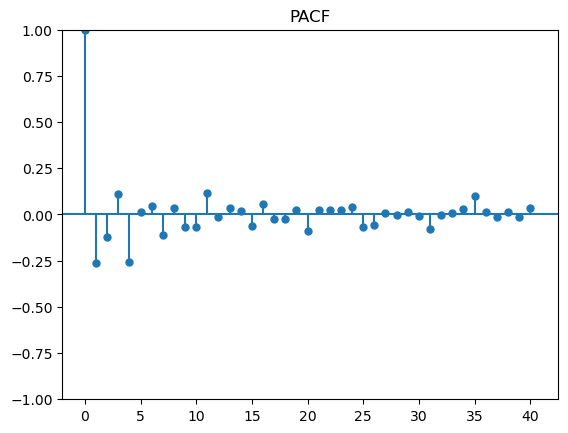

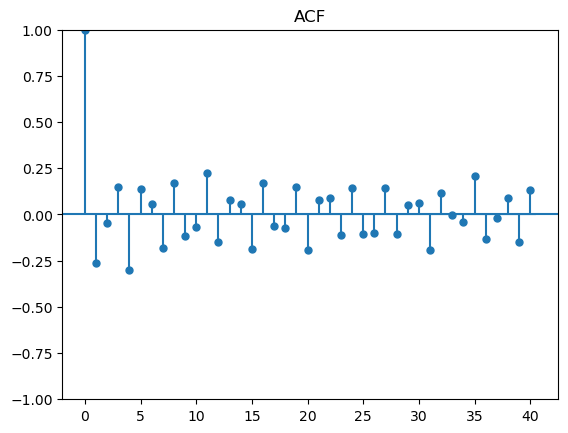

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(diff_seasonal.dropna(), lags=40)
plt.title('PACF')
pacf.show()
acf = plot_acf(diff_seasonal.dropna(), lags=40)
plt.title('ACF')
acf.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 拟合SARIMA模型
model = SARIMAX(df1, order=(1, 1, 1), seasonal_order=(1, 1, 1, 60))
fitted_model = model.fit()
print(fitted_model.summary())

# LSTM

In [66]:
# 进行预测填补缺失值
start_loc = df.index.get_loc('2024/2/3 23:59:45')+1
end_loc = df.index.get_loc('2024/2/20 0:00:00')
time_step = end_loc-start_loc

In [51]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
time_step = 60
pred_esteps = end_loc-start_loc

# 将数据转换为 NumPy 数组
data_values = df1.values.reshape(-1, 1)

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

# 创建数据集用于训练 LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


X, y = create_dataset(data_scaled, time_step)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape(-1,1)

y

array([[0.17214081],
       [0.17230925],
       [0.17315142],
       ...,
       [0.03486609],
       [0.03486609],
       [0.0353714 ]])

In [52]:
# 创建 LSTM 模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(pred_esteps))  # 预测未来多步
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X, y, epochs=5, batch_size=30, verbose=2)

Epoch 1/5


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17854/17854 - 806s - 45ms/step - loss: 8.1846e-04
Epoch 2/5
17854/17854 - 815s - 46ms/step - loss: 2.6022e-04
Epoch 3/5
17854/17854 - 813s - 46ms/step - loss: 2.5424e-04
Epoch 4/5
17854/17854 - 810s - 45ms/step - loss: 2.5079e-04
Epoch 5/5
17854/17854 - 802s - 45ms/step - loss: 2.4795e-04


In [61]:
# 使用模型进行预测
test_data = data_scaled[-time_step:]
test_data = test_data.reshape((1, time_step, 1))
predicted = model.predict(test_data)
# 反归一化预测结果
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))

predicted.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(92160, 1)

In [62]:
df.loc[(df.index >= '2024-02-04') & (df.index < '2024-02-20')] = predicted
df

,FH
2023-11-03 00:00:00,73.8
2023-11-03 00:00:15,73.2
2023-11-03 00:00:30,74.1
2023-11-03 00:00:45,75.5
2023-11-03 00:01:00,75.5
...,...
2024-03-17 23:58:45,63.6
2024-03-17 23:59:00,63.6
2024-03-17 23:59:15,63.9
2024-03-17 23:59:30,63.6


# Prophet

In [14]:
# 进行预测填补缺失值
start_loc = df.index.get_loc('2024/2/3 23:59:45')+1
end_loc = df.index.get_loc('2024/2/20 0:00:00')
pred_step = end_loc-start_loc
pred_step

92160

In [15]:
df1.columns = ['y']
df1['y'] = np.log(df1['y']+1)
df1['ds'] = df1.index
df1

C:\Users\25492\AppData\Local\Temp\ipykernel_14760\4208876233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['y'] = np.log(df1['y']+1)
C:\Users\25492\AppData\Local\Temp\ipykernel_14760\4208876233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ds'] = df1.index


,y,ds
2023-11-03 00:00:00,4.314818,2023-11-03 00:00:00
2023-11-03 00:00:15,4.306764,2023-11-03 00:00:15
2023-11-03 00:00:30,4.318821,2023-11-03 00:00:30
2023-11-03 00:00:45,4.337291,2023-11-03 00:00:45
2023-11-03 00:01:00,4.337291,2023-11-03 00:01:00
...,...,...
2024-02-03 23:58:45,3.049273,2024-02-03 23:58:45
2024-02-03 23:59:00,3.063391,2024-02-03 23:59:00
2024-02-03 23:59:15,3.077312,2024-02-03 23:59:15
2024-02-03 23:59:30,3.077312,2024-02-03 23:59:30


In [16]:
from prophet import Prophet

# 创建模型
model = Prophet()
# 添加自定义季节性
model.add_seasonality(name='15min', period=60, fourier_order=5)
# 拟合模型
model.fit(df1)



16:34:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# 创建未来数据框
future = model.make_future_dataframe(periods=pred_step, freq='15s')

# 进行预测
forecast = model.predict(future)

D:\Anaconda\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
D:\Anaconda\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


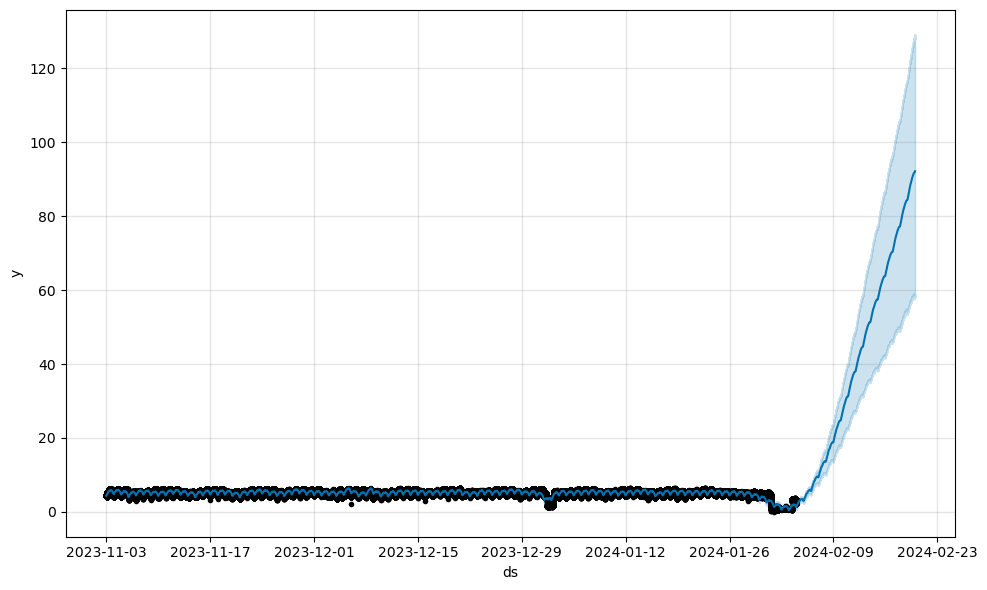

In [18]:
# 可视化结果
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.show()

In [19]:
pred = np.exp(forecast['yhat']-1)
pred

0         2.874176e+01
1         2.875056e+01
2         2.875946e+01
3         2.876845e+01
4         2.877754e+01
              ...     
627835    3.862417e+39
627836    3.868253e+39
627837    3.874109e+39
627838    3.879987e+39
627839    3.885886e+39
Name: yhat, Length: 627840, dtype: float64

In [29]:
df1.shape

(535680, 2)

In [64]:
df.to_csv( '单柜补全数据.csv')

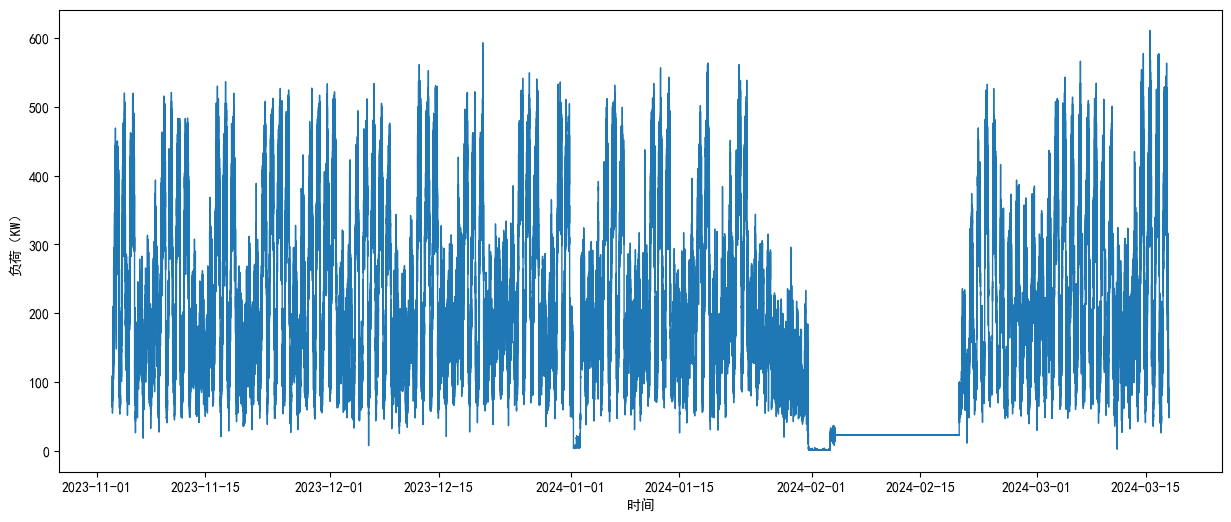

In [65]:
plt.figure(figsize=(15, 6))
plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False
plt.plot(df.index, df['FH'], linewidth=1)
plt.xlabel('时间')
plt.ylabel('负荷（KW）')
#plt.savefig('三并柜负荷随时间变化图.png',dpi=500)
plt.show()